# 3) Quantum Classification

In [1]:
import numpy as np
import seaborn as sns
import time

from matplotlib import pyplot as plt
from IPython.display import clear_output
from multiprocessing import Pool

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.datasets import load_iris, make_blobs
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_machine_learning.algorithms import QSVC
from qiskit_ibm_runtime.fake_provider import FakeBoeblingen
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, RealAmplitudes, EfficientSU2
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler

## Support Vector Classifiers

We would like to compare the capabilities of classifying data using classical algorithms, compared to quantum algorithms. For our classical algorithm, we implement a __Support Vector Classifier (SVC)__. Recall, a SVC is a supervised learning classifier that finds a hyperplane using the kernel trick that correctly separates two classes with a maximum margin.

In [2]:
iris = load_iris()     # Dataset
X = iris.data          # 4 features x 150 samples (50 per 1 of 3 labels)
y = iris.target        # 3 labels

# Scale feature data to [0,1]
X = MinMaxScaler().fit_transform(X)

# Partition training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

# Create classifier and fit training data
svc = SVC(kernel="rbf", random_state=123)
svc.fit(X_train, y_train)

# Test performance of classical model
train_score_classical = svc.score(X_train, y_train)
test_score_classical = svc.score(X_test, y_test)
print(f"Classical SVC on the training dataset: {train_score_classical:.3f}")
print(f"Classical SVC on the test dataset:     {test_score_classical:.3f}")

Classical SVC on the training dataset: 0.992
Classical SVC on the test dataset:     0.967


The SVC performs very well on the data!

In [3]:
# Visualize the data
plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="tab10");

# Quantum SVC

The __QSVC__ class within Qiskit serves as an extension to SVC from its Scikit-learn class. In order to use QSVC, we first need a kernel to equip it with. To define the kernel we require a feature map and a fidelity. The __fidelity__ would simply give an assessment of two quantum states when overlapping them. We require a __Sampler__ primitive for the fidelity, which supplies distributions for the circuit.

__Quantum Feature Maps__ are parameterized quantum circuits that encode the data.  The __ZZFeatureMap__ encodes interactions in the data according to the connectivity graph and the classical data map. The parameters we need to specify are how many features the data has, and how many repetitions we would like to apply. More repetitions lead to more entanglement.

In [4]:
feature_map = ZZFeatureMap(feature_dimension=3, reps=2, entanglement="linear")
sampler = Sampler()     # ComputeUncompute would define Sampler default; here for demonstration
fidelity = ComputeUncompute(sampler=sampler)     # combine circuit for comparison circuit
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map) # classification kernel

We can now prepare and fit the classifier and obtain a score.

In [5]:
# Quantum SVC with quantum kernel
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(X_train, y_train)
qsvc_score = qsvc.score(X_test, y_test)

print(f"QSVC score: {qsvc_score}")

QSVC score: 0.9


How does this compare with implementing a classical SVC? And how would the quantum kernel act on the classical SVC if we were to evaluate it for use with SVC?

In [6]:
# Classical SVC with evaluated quantum kernel
matrix_train = kernel.evaluate(x_vec=X_train)
matrix_test = kernel.evaluate(x_vec=X_test, y_vec=X_train)

prec_svc = SVC(kernel="precomputed", random_state=123)
prec_svc.fit(matrix_train, y_train)
prec_score = prec_svc.score(matrix_test, y_test)

# Classical SVC with classical linear kernel
lin_svc = SVC(kernel="linear", random_state=123)
lin_svc.fit(X_train, y_train)
score = lin_svc.score(X_test, y_test)

# Print scores
print(f"Precomputed kernel SVC score: {prec_score}")
print(f"Linear SVC score: {score}")

Precomputed kernel SVC score: 0.9
Linear SVC score: 0.9333333333333333


Notice two things: <br>
(1) The QSVC score is the same as the precomputed SVC score, as it should be, since QSVC simply inherits SVC and they used the same kernel. <br>
(2) The linear SVC actually outperformed the QSVC. This is often the case currently as quantum kernels are still to improve a lot. For a large dataset, a quantum kernel might be evaluated much faster with reasonable accuracy, but for superior accuracy, classical kernels are still more accurate.

In [7]:
# Visualize the kernel matrices
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(
    np.asmatrix(matrix_train), interpolation="nearest", origin="upper", cmap="Blues"
)
axs[0].set_title("Training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test), interpolation="nearest", origin="upper", cmap="Reds")
axs[1].set_title("Testing kernel matrix")
plt.show()

### Exercise 1:

Often it is useful to apply Principal Component Analysis (PCA) to reduce the amount of features for algorithms. This technique trades possibly weaker accuracy for faster computation and probably easier comprehension.

Use PCA to reduce the amount of features of the iris data to 2. Plot the reduced data points. Perform QSVC and SVC on the reduced data. Compare the two scores with each other and with the non-reduced QSVC and SVC scores. 

Useful methods are __PCA__ and __fit_transform__.

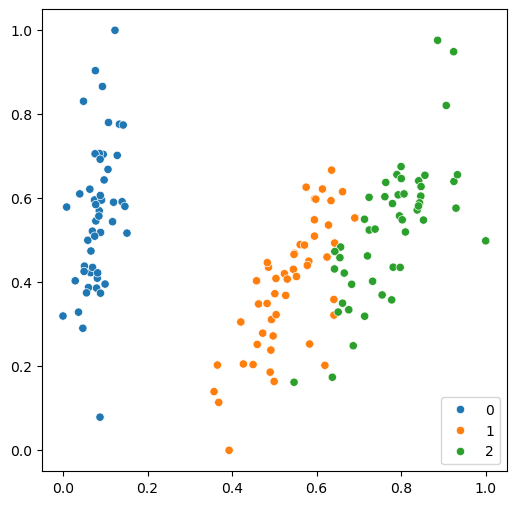

In [8]:
X_PCA = PCA(n_components=2).fit_transform(X)
X_PCA = MinMaxScaler().fit_transform(X_PCA)

plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X_PCA[:, 0], y=X_PCA[:, 1], hue=y, palette="tab10");

In [9]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
fidelity = ComputeUncompute(sampler=Sampler()) 
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

In [10]:
pca_X_train, pca_X_test, pca_y_train, pca_y_test = train_test_split(X_PCA, y, train_size=0.8, random_state=123)
qsvc = QSVC(quantum_kernel=kernel)
qsvc.fit(pca_X_train, pca_y_train)

print(f"QSVC score: {qsvc.score(pca_X_test, pca_y_test)}")

QSVC score: 0.9333333333333333


In [11]:
pca_matrix_train = kernel.evaluate(x_vec=pca_X_train)
pca_matrix_test = kernel.evaluate(x_vec=pca_X_test, y_vec=pca_X_train)

pca_prec_svc = SVC(kernel="precomputed", random_state=123)
pca_prec_svc.fit(pca_matrix_train, pca_y_train)
pca_prec_score = pca_prec_svc.score(pca_matrix_test, pca_y_test)

# Classical SVC with classical linear kernel
pca_lin_svc = SVC(kernel="linear", random_state=123)
pca_lin_svc.fit(pca_X_train, pca_y_train)
pca_score = pca_lin_svc.score(pca_X_test, pca_y_test)

# Print scores
print(f"Precomputed kernel SVC score: {pca_prec_score}")
print(f"Linear SVC score: {pca_score}")

Precomputed kernel SVC score: 0.9333333333333333
Linear SVC score: 0.8666666666666667


Notice that the scores with classical kernels decreased, whereas the scores with the quantum kernel increased. Thus the quantum kernel could actually outperform the classical kernel.

# Clustering

An example of unsupervised learning classification that can make use of quantum techniques is Clustering. Spectral clustering particularly groups data points into $n$ many 'clusters' by minimizing the sum-of-squares within each cluster. Compared to SVC, qiskit does not have a quantum analogous implementation, but evaluated quantum kernels can still be used on the classical algorithms. 

### Exercise 2:
Create a quantum kernel, evaluate it, and apply it to a SpectralClustering classifier to get a clustering score. Also implement a SpectralClustering classifier with the default kernel and get a clustering score. Compare and describe the two scores.

Useful methods are __fit\_predict__ and __normalized\_mutual\_info\_score__

In [12]:
X, y = make_blobs(n_samples=200, cluster_std=[1.5, 2.0, 0.5], random_state=100)
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=100)

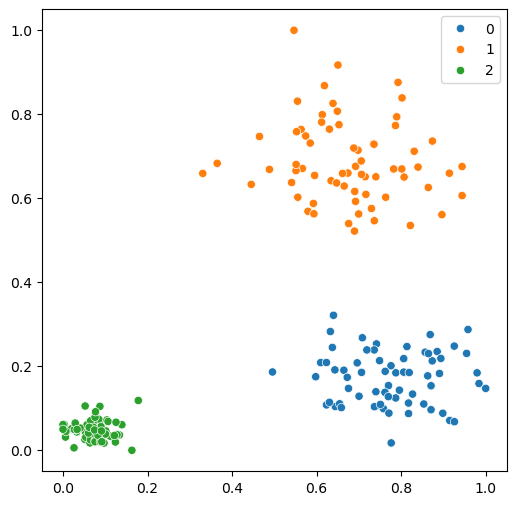

In [13]:
plt.clf()
plt.rcParams["figure.figsize"] = (6, 6)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="tab10");

In [14]:
feature_map = ZZFeatureMap(feature_dimension=2, reps=2, entanglement="linear")
fidelity = ComputeUncompute(sampler=Sampler())     
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)
matrix = kernel.evaluate(x_vec=X)

In [15]:
spectral = SpectralClustering(3, affinity="precomputed", random_state=100)
cluster_labels = spectral.fit_predict(matrix)
cluster_score = normalized_mutual_info_score(cluster_labels, y)

print(f"Quantum Kernel clustering score: {cluster_score}")

Quantum Kernel clustering score: 0.9763112474994169


In [16]:
c_spectral = SpectralClustering(3, assign_labels='discretize', random_state=100)
c_labels = c_spectral.fit_predict(X)
c_score = normalized_mutual_info_score(c_labels, y)
print(f"Clustering score: {c_score}")

Clustering score: 1.0


## Variational Quantum Classifier

In [17]:
X = iris.data    
y = iris.target
X = MinMaxScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=123)

Now we would like to classify the data using a quantum algorithm. One of the simplest classifiers is the __Variational Quantum Classifier (VQC)__. We will need to define a few new concepts.

In [20]:
X_map = ZZFeatureMap(feature_dimension=X.shape[1], reps=1)

We need to apply an __ansatz__ (classifier), which is another parameterized quantum circuit with the intention that optimizing its parameters minimizes the cost function. More repetitions lead to more trainable parameters.

In [21]:
ansatz = RealAmplitudes(num_qubits=X.shape[1], reps=3)

We require an __optimizer__ for the training process. Notable (local) optimizers available in qiskit, amongst others, are ADAM, SPSA and COBYLA. We do require a Sampler primitive again, but with ommission of its declaration, the VQC will later define a simple Sampler anyway.

In [22]:
optimizer = COBYLA(maxiter=100)

Lastly, we require a __callback function__ in order to plot the progression of the algorithm as it gets closer to its optimum (evaluation of the cost function).

In [23]:
vals = []     # clear cost history
plt.rcParams["figure.figsize"] = (12, 6)

# VQC calls for each evaluation of objective function
# 2 param: weights and objective function at weights
def callback_graph(weights, obj_eval):
    clear_output(wait=True)
    vals.append(obj_eval)
    plt.title("Cost against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.plot(range(len(vals)), vals)
    plt.show()

We can finally implement the VQC now, we have defined all the necessary tools.

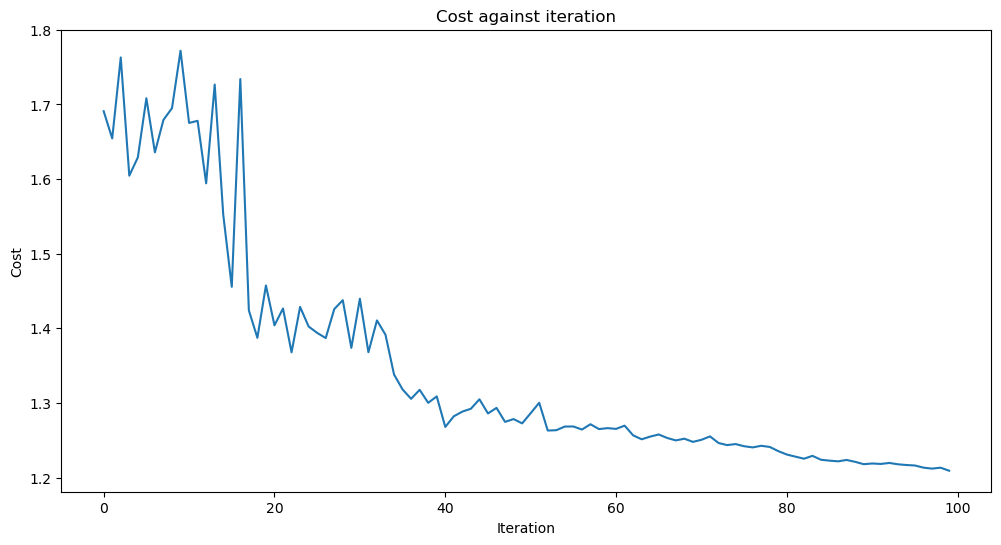

Training time: 64 seconds


In [24]:
#Initialize VQC
vqc = VQC(feature_map=X_map, ansatz=ansatz, optimizer=optimizer,
          callback=callback_graph)

vals = []
start = time.time()
vqc.fit(X_train, y_train)      # Fit the training set to VQC
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [30]:
# Test performance of quantum model
train_score_quantum = vqc.score(X_train, y_train)
test_score_quantum = vqc.score(X_test, y_test)
print(f"VQC on the training dataset: {train_score_quantum:.2f}")
print(f"VQC on the test dataset:     {test_score_quantum:.2f}")

VQC on the training dataset: 0.73
VQC on the test dataset:     0.70


These results might be lower than that of the SVC, but they are still high enough for predicting labels reasonably accurately. Looking at the graph, we can see how the optimizer minimized the cost function value generally iteration after iteration, and how after 100 iterations, the cost stabilized. 

## Benchmarking

### Exercise 3:

Create a benchmark for VQC with the following considerations: <br>
Ansatz: RealAmplitudes, EfficientSU2 <br>
Ansatz repetitions: 1, 3 <br>
Optimizers: COBYLA, SPSA <br>
Optimizer max iterations: 40, 80  <br>
Compare the scores and name which one performed the best <br>
(First make an empty folder called _vqc_graphs_ to output into)

In [31]:
def print_name(obj):
    for name, o in globals().items():
        if o is obj:
            return name

RA1 = RealAmplitudes(num_qubits=X.shape[1], reps=1)
RA3 = RealAmplitudes(num_qubits=X.shape[1], reps=3)
ESU1 = EfficientSU2(num_qubits=X.shape[1], reps=1)
ESU3 = EfficientSU2(num_qubits=X.shape[1], reps=3)

cobyla40 = COBYLA(maxiter=40)
cobyla80 = COBYLA(maxiter=100)
spsa40 = SPSA(maxiter=40)
spsa80 = SPSA(maxiter=100)

ansatzs = (RA1, RA3, ESU1, ESU3)
optimizers = (cobyla40, cobyla80, spsa40, spsa80)
benches = [(a, b, [], f"{print_name(a)}_{print_name(b)}", 0) for a in ansatzs for b in optimizers]
        
def benchmark(ansatz, optimizer, values, name, timer):
    def callback(weights, cost):
        clear_output(wait=True)
        elapsed = time.time() - timer
        values.append(cost)
        plt.title(f"{name} with cost {cost:.4f} and elapsed time {elapsed:.2f}sec.")
        plt.xlabel("Iteration")
        plt.ylabel("Cost")
        plt.plot(range(len(values)), values)
        plt.savefig(f"vqc_graphs/{name}_cost.png") 
        plt.show()
    
    vqc_bench = VQC(feature_map=X_map, ansatz=ansatz, optimizer=optimizer, 
          callback=callback)
    
    timer = time.time()
    vqc_bench.fit(X_train, y_train) 

    train_vqc_bench = vqc_bench.score(X_train, y_train)
    test_vqc_bench = vqc_bench.score(X_test, y_test)
    
    sfile = open('vqc_graphs/Scores.txt', 'a')
    scores = f"Name: {name}, Train_score: {train_vqc_bench:.4f}, Test_score: {test_vqc_bench:.4f}\n"
    sfile.write(scores)
    sfile.close()

In [32]:
with Pool(processes=None) as pool:
    pool.starmap(benchmark, benches)

This should run for about 8min. or so. The long processes are the ones with spsa80 (if you'd like to save some time).

What did you find? Which one performed best? How does the elapsed time, scores and cost relate to each other?

## Additional exercise!

### Exercise 4:

Since real quantum processors in the current NISQ era are prone to decoherence, circuits such as feature maps and ansatzes are often restricted to low repetitions in order to get meaningful results. To illustrate this, we can run jobs with a noiseless simulator, _AerSimulator_, and noisy simulator, _FakeBoeblingen_, which has decoherence settings similar to what is expected at the real Boeblingen IBM QPU.

Consider the given quantum circuit below. Change the quantity of repetitions of the feature map and ansatz; for example (1,1) (1,3) (1,5) (3,1) (3,3) (5,1) (5,3) (5,5). Run these repetition pairs for the circuit with 10000 shots each, and compare the measurements in a graph. Can you see how the decoherence enters the system?

In [2]:
n_qubits = 4
reps_fm = 5
reps_az = 5

circuit_fm = ZZFeatureMap(feature_dimension=n_qubits, reps=reps_fm)
params_fm = np.arange(0,n_qubits,1) * (np.pi / n_qubits)
binded_fm = circuit_fm.assign_parameters(params_fm)

circuit_az = EfficientSU2(num_qubits=n_qubits, reps=reps_az)
params_az = np.random.uniform(0, 2 * np.pi, n_qubits * (2 * reps_az + 2))
binded_az = circuit_az.assign_parameters(params_az)

binded_circuit = binded_fm.compose(binded_az)
binded_circuit.measure_all()
binded_circuit.decompose().draw(output='mpl')

In [3]:
# NOISELESS SIMULATOR
exact_backend = AerSimulator(method='statevector')
transpiled_exact_circuit = transpile(binded_circuit, exact_backend)
exact_job = exact_backend.run(transpiled_exact_circuit, shots=10000)
exact_counts = exact_job.result().get_counts()
plot_histogram(exact_counts)

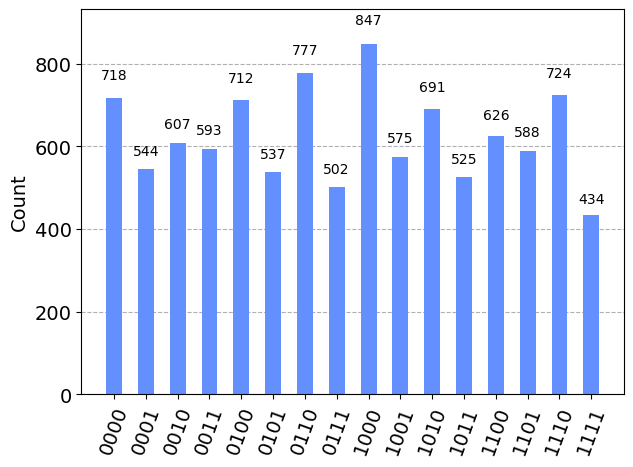

In [4]:
# NOISY SIMULATOR
noise_backend = FakeBoeblingen()
transpiled_noise_circuit = transpile(binded_circuit, noise_backend)
noise_job = noise_backend.run(transpiled_noise_circuit, shots=10000)
noise_counts = noise_job.result().get_counts()
plot_histogram(noise_counts)

### Exercise 5:

Create your own! Recall the fidelity kernel that was defined for QSVC above. It did a good job, but it could be better maybe. Especially if the score was low would we need a technique to improve the kernel. Quantum Kernel Alignment (QKA) does the trick to maximise the margin using a parameterized quantum kernel. 

Using __QuantumKernelTrainer__ and __TrainableFidelityQuantumKernel__, train a quantum kernel and fit it to the data. See if you can find a score better than that of the QSVC above. Visualise the kernel matrix.

In [33]:
# QKA CODE